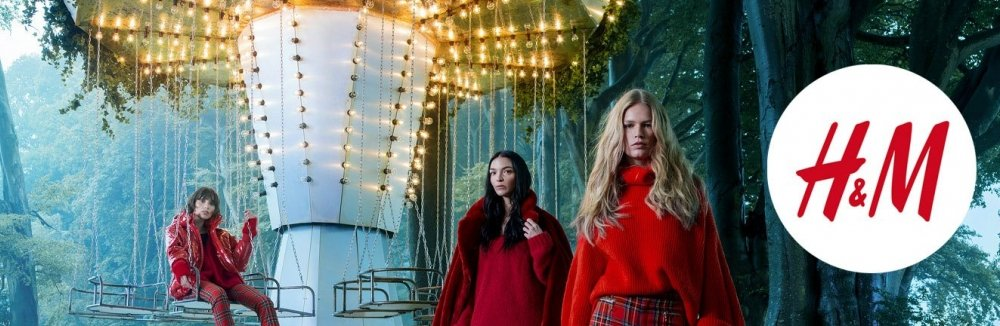

# Data Preparation

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor, KNNBasic

# from sklearn.model_selection import train_test_split

plt.style.use('fast')
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 50)

Read in the `out` file which is the data prepared for the collaborative modeling in the `FinalDataPreparation` notebook.

In [4]:
transactions = pd.read_csv('Data/out.zip')
transactions.head(3)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1


In [5]:
transactions.shape

(671674, 8)

In [6]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

In [8]:
transactions.customer_id[1]

'002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'

Transactions data description:

- t_dat : A unique identifier of every customer
- customer_id : A unique identifier of every customer (in customers table)
- article_id : A unique identifier of every article (in articles table)
- price : Price of purchase
- sales_channel_id : 1 or 2

### Surprise Data & Split 

In [9]:
# Instantiate reader the same convention as a sklearn class
reader = Reader(rating_scale = (0,1))
# Load user_data from imported dataframe specifiyng which columns to use
customer_data = Dataset.load_from_df(transactions[['customer_id', 'article_id', 'bought']], reader)

In [10]:
type(customer_data)

surprise.dataset.DatasetAutoFolds

In [11]:
# Perform an appropriate split for the recommendation models
trainset, testset = train_test_split(customer_data, test_size=0.2, random_state=42)

In [12]:
#How many users and items are in the trainset
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  172712 

Number of items:  9225 



## Modeling

### Baselines without cross validation

In [12]:
# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 0.0000


In [13]:
# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.0000


### SVD

In [36]:
svd_model = SVD()
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)
svd_simple_predictions = accuracy.rmse(svd_predictions)
svd_simple_predictions

RMSE: 0.0463


0.04634143319111156

In [37]:
svd_model.predict('0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', 902802002)

Prediction(uid='0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2', iid=902802002, r_ui=None, est=0.8988532711706756, details={'was_impossible': False})

In [38]:
transactions.loc[(transactions['customer_id'] == '0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2') & 
                 (transactions['article_id'] == 902802002)]

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought


In [ ]:
param_grid = {'n_factors':[10,50],'n_epochs': [5, 15], 'lr_all': [0.002,0.01],
             'reg_all': [0.2,0.6]}
gs_model_SVD1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD1.fit(customer_data)

gs_model_SVD1.best_params

explain

In [ ]:
param_grid2 = {'n_factors':[5,10],'n_epochs': [15, 50], 'lr_all': [0.001, 0.01],
             'reg_all': [0.6, 0.8]}
gs_model_SVD2 = GridSearchCV(SVD,param_grid=param_grid2,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD2.fit(customer_data)

gs_model_SVD2.best_params

explain

In [ ]:
param_grid3 = {'n_factors':[10],'n_epochs': [50, 100], 'lr_all': [0.1, 0.2],
             'reg_all': [0.8, 0.9]}
gs_model_SVD3 = GridSearchCV(SVD,param_grid=param_grid3,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD3.fit(customer_data)

gs_model_SVD3.best_params

In [ ]:
param_grid4 = {'n_factors':[10],'n_epochs': [100, 150], 'lr_all': [0.2, 0.3],
             'reg_all': [0.7, 0.8]}
gs_model_SVD4 = GridSearchCV(SVD,param_grid=param_grid4,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_SVD4.fit(customer_data)

gs_model_SVD4.best_params

We find the best parameters for SVD modeling are - 
- n_factors : 10
- n_epochs : 100
- lr_all :0.2
- reg_all : 0.8

Now we build a model with the best parameters and test it on our testset.

In [39]:
svd_model2 = SVD(n_factors= 10, n_epochs= 50)
svd_model2.fit(trainset)
svd_predictions2 = svd_model2.test(testset)
svd_tuned_predictions = accuracy.rmse(svd_predictions2)
svd_tuned_predictions

RMSE: 0.0115


0.011460277893248154

### NFM 

Now, we explore the `Non-negative Matrix Factorization (NMF)` from the `suprise` library. The only difference between this algorithm and the previous algorithm SVD is that in NMF, a specific step size is set for the stochastic gradient descent process of regularization. This is done to ensure that all user and item factors are kept positive. While this model can be prone to over-fitting, this can be mitigated with steps to reduce the dimensionality of our data/factors.

In [18]:
nmf_model = NMF()
nmf_model.fit(trainset)
nmf_predictions = nmf_model.test(testset)
nmf_simple_predictions = accuracy.rmse(nmf_predictions)
nmf_simple_predictions

RMSE: 0.0676


0.0676350352956524

In [ ]:
param_grid = {'n_factors':[10,15,20],'n_epochs': [25, 50, 75]}
gs_model_NFM = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM.fit(customer_data)

gs_model_NFM.best_params

explain

In [ ]:
param_grid = {'n_factors':[10],'n_epochs': [75, 100]}
gs_model_NFM2 = GridSearchCV(NMF,param_grid=param_grid,joblib_verbose=5, measures=['RMSE'], n_jobs=-2)
gs_model_NFM2.fit(customer_data)

gs_model_NFM2.best_params

Explain

We find the best parameters for NMF modeling are - 
- n_factors : 10
- n_epochs : 100

Now we build a model with the best parameters and test it on our testset.

In [19]:
nmf_model2 = NMF(n_factors = 10, n_epochs = 100)
nmf_model2.fit(trainset)
nmf_predictions2 = nmf_model2.test(testset)
nmf_tuned_predictions = accuracy.rmse(nmf_predictions2)

nmf_tuned_predictions

RMSE: 0.0582


0.05823298887397602

## SVD ++ 

For a final look at models from the `surprise` library, I wanted to try and utilize the SVD++ algorithm, again, very similar to SVD. The difference is that SVD++ attempts to add an extension onto the base SVD that uses implicit rating as well as explicit. In other words it infers the action of rating an item as a latent factor regardless of the rating value given to the item while also factoring the actual rating value. I thought this might further improve the RMSE by taking into account reviewers who have rated a large number of eBooks. Please note that this Grid Search will take a very long time to run.

In [20]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp()
SVDpp_model.fit(trainset)
SVDpp_predictions = SVDpp_model.test(testset)
svdpp_simple_predictions = accuracy.rmse(SVDpp_predictions)

svdpp_simple_predictions

RMSE: 0.0206


0.020647204882569048

In [ ]:
# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[1, 5], 'n_epochs':[25, 50], 'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model.fit(customer_data)

svdpp_gs_model.best_params

explain

In [ ]:
# New dictionary for SVD++
svdpp_param_grid2 = {'n_factors':[1], 'n_epochs':[50, 100], 'reg_all':[0.05, 0.1]}
svdpp_gs_model2 = GridSearchCV(SVDpp, param_grid=svdpp_param_grid2, cv=3, joblib_verbose=5, n_jobs=-2, measures=['RMSE'])

# Fit and return the best_params based on cross validation this will take a VERY long time to run
svdpp_gs_model2.fit(customer_data)

svdpp_gs_model2.best_params

We find the best parameters for SVD ++ modeling are - 
- n_factors : 1
- n_epochs : 100
- reg_all : 0.1

Now we build a model with the best parameters and test it on our testset.

In [22]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model2 = SVDpp(n_factors=1, n_epochs=100, reg_all=0.1)
SVDpp_model2.fit(trainset)
SVDpp_predictions2 = SVDpp_model2.test(testset)
svdpp_tuned_predictions = accuracy.rmse(SVDpp_predictions2)

svdpp_tuned_predictions

RMSE: 0.0008


0.0008434432468881647

## Model Performance

In [23]:
# # just to code ahead! 
baseline_only = 0.00
svd_simple_predictions = 0.0463
svd_tuned_predictions = 0.0115
nmf_simple_predictions = 0.0676
nmf_tuned_predictions = 0.0582
svdpp_simple_predictions = 0.0206
svdpp_tuned_predictions = 0.0207

In [24]:
X = ['Baseline', 'SVD Basic', 'SVD Tuned', 'NMF Basic', 'NMF tuned', 'SVD ++ Basic', 'SVD ++ Tuned']
y = [baseline_only, svd_simple_predictions, svd_tuned_predictions, nmf_simple_predictions, nmf_tuned_predictions, svdpp_simple_predictions, svdpp_tuned_predictions]

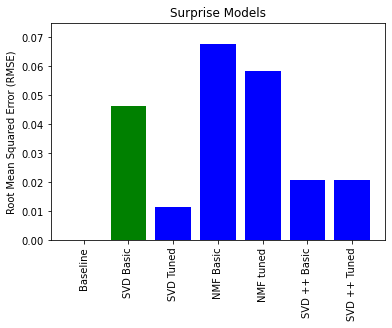

In [26]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'green', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(rotation=90)
plt.ylim(0, .075)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.savefig('Images/Model_bar.png', dpi=500, bbox_inches='tight');

# Recommendation Function

### Building

##### Final Model

In [43]:
# Using Surprise a full trainset incorporating all data can be built and fit to the model in order to make full predictions
trainset_full = customer_data.build_full_trainset()

In [44]:
final_model = SVD(n_factors= 10, n_epochs= 50)
final_model.fit(trainset_full)

In [45]:
# The model is pickled and saved into the Model folder in the repository so it can used in the app.py file
pickle.dump(final_model, open('Model/collaborative_model.sav', 'wb'))

In [46]:
collab_model = pickle.load(open('Model/collaborative_model.sav', 'rb'))

In [47]:
transactions.tail(10)

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
671664,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,651591001,0.032186,2,2020-09-22,2020-09-22,1
671665,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,864339003,0.022017,2,2020-09-22,2020-09-22,1
671666,2020-09-22,ff732b98019465f078144bae647d7d9765d76e3431ef92...,938667001,0.010153,2,2020-09-22,2020-09-22,1
671667,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846006,0.025407,2,2020-09-22,2020-09-22,1
671668,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,762846027,0.025407,2,2020-09-22,2020-09-22,1
671669,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22,1
671670,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22,1
671671,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22,1
671672,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22,1
671673,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,740519002,0.045746,2,2020-09-22,2020-09-22,1


Start from here... 
- we have to load the articles df here as meta data with article id as the index 
- build function

In [48]:
# Load in the meta data for use in returning the details about the recommended articles 
meta_articles = pd.read_csv('Data/articles.csv.zip', index_col='article_id')
meta_articles.head(3)

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [49]:
# sanity check
meta_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105542 entries, 108775015 to 959461001
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product_code                  105542 non-null  int64 
 1   prod_name                     105542 non-null  object
 2   product_type_no               105542 non-null  int64 
 3   product_type_name             105542 non-null  object
 4   product_group_name            105542 non-null  object
 5   graphical_appearance_no       105542 non-null  int64 
 6   graphical_appearance_name     105542 non-null  object
 7   colour_group_code             105542 non-null  int64 
 8   colour_group_name             105542 non-null  object
 9   perceived_colour_value_id     105542 non-null  int64 
 10  perceived_colour_value_name   105542 non-null  object
 11  perceived_colour_master_id    105542 non-null  int64 
 12  perceived_colour_master_name  105542 non-null  

In [50]:
transactions.head()

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1
3,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,918292001,0.042356,2,2020-09-03,2020-09-03,1
4,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000001,0.050831,2,2020-09-03,2020-09-03,1


In [51]:
# The transactions data is subset to just show customers and the articles they have bought
df_customer = transactions.set_index('customer_id')
df_customer.drop(columns=['InvoiceDate', 'price', 'sales_channel_id', 't_dat', 'date', 'bought'], inplace=True)
df_customer.head()

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001


In [52]:
# Save the `df_customer` as a new csv

df_customer.to_csv('Data/df_customer.csv')

In [53]:
pd.read_csv('Data/df_customer.csv', index_col='customer_id')

,article_id
customer_id,
0008968c0d451dbc5a9968da03196fe20051965edde7413775c4eb3be9abe9c2,893059004
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,902802002
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000007
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,918292001
002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc,805000001
...,...
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,914404001
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471041
ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3758cc7fa0cf65ba441,751471038


In [54]:
# Dual input for unique customer ID and how many recommendations you would like
customer = input('CustomerID: ')
n_recs = int(input('How many recommendations? '))

CustomerID: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc
How many recommendations? 10


In [55]:
# Creating a list of the eBooks that said reviewer has already rated
have_bought = list(df_customer.loc[customer, 'article_id'])
have_bought

[902802002, 805000007, 918292001, 805000001, 730683050, 910824001]

In [56]:
# Creating new dataframe from meta data to subset based on already bought articles
not_bought = meta_articles.copy()
# Dropping indexes (article_id) that correspond to already bought articles
not_bought.drop(have_bought, inplace=True)
# Reset index to pull out article_id as a seperate column
not_bought.reset_index(inplace=True)
not_bought.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [57]:
# Obtain rating predictions based on model.predict, passing in user input. 
# Using .apply with lamdba function to iterate through
not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
# Sort dataframe based on newly created est_purchase problem in order to return top estimated ratings (purcahse in this case)
not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
not_bought.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
90847,845046004,845046,ED Samson,254,Top,Garment Upper body,1010016,Solid,73,Dark Blue,4,Dark,2,Blue,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Top in soft cotton jersey with a boat neck and...,1.0
99436,884535001,884535,&DENIM+ Girlfriend RW,272,Trousers,Garment Lower body,1010023,Denim,72,Blue,2,Medium Dusty,2,Blue,1774,OL Extended Sizes,A,Ladieswear,1,Ladieswear,57,Ladies Denim,1016,Trousers Denim,"5-pocket jeans in washed, stretch denim. Loose...",1.0
91082,846399002,846399,Shirt Oversize,259,Shirt,Garment Upper body,1010023,Denim,73,Dark Blue,2,Medium Dusty,2,Blue,1773,Denim Other Garments,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,Oversized shirt in soft cotton denim with a co...,1.0
91081,846399001,846399,Shirt Oversize,259,Shirt,Garment Upper body,1010023,Denim,71,Light Blue,1,Dusty Light,2,Blue,1773,Denim Other Garments,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,Oversized shirt in soft cotton denim with a co...,1.0
54670,708311004,708311,vermont fancy slacks (1),272,Trousers,Garment Lower body,1010026,Other structure,12,Light Beige,1,Dusty Light,11,Beige,1717,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,Ankle-length trousers in woven fabric with cre...,1.0


In [58]:
not_bought['est_purchase'].tail()

15244     0.911352
39        0.909151
103757    0.907085
87588     0.904884
83862     0.901108
Name: est_purchase, dtype: float64

In [59]:
# Captilizing column names for a more appealing final display
not_bought.rename(columns={'prod_name':'Product Name', 'author':'Author',
                               'product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name ':'Garment Group Name'}, inplace=True)

In [60]:
# Final step is to only return the top n_recs as denoted by input, done using .head(n_recs)
not_bought.head(n_recs)

,article_id,product_code,Product Name,product_type_no,Product Type Name,Product Group Name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,Index Group Name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,est_purchase
90847,845046004,845046,ED Samson,254,Top,Garment Upper body,1010016,Solid,73,Dark Blue,4,Dark,2,Blue,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Top in soft cotton jersey with a boat neck and...,1.0
99436,884535001,884535,&DENIM+ Girlfriend RW,272,Trousers,Garment Lower body,1010023,Denim,72,Blue,2,Medium Dusty,2,Blue,1774,OL Extended Sizes,A,Ladieswear,1,Ladieswear,57,Ladies Denim,1016,Trousers Denim,"5-pocket jeans in washed, stretch denim. Loose...",1.0
91082,846399002,846399,Shirt Oversize,259,Shirt,Garment Upper body,1010023,Denim,73,Dark Blue,2,Medium Dusty,2,Blue,1773,Denim Other Garments,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,Oversized shirt in soft cotton denim with a co...,1.0
91081,846399001,846399,Shirt Oversize,259,Shirt,Garment Upper body,1010023,Denim,71,Light Blue,1,Dusty Light,2,Blue,1773,Denim Other Garments,D,Divided,2,Divided,57,Ladies Denim,1016,Trousers Denim,Oversized shirt in soft cotton denim with a co...,1.0
54670,708311004,708311,vermont fancy slacks (1),272,Trousers,Garment Lower body,1010026,Other structure,12,Light Beige,1,Dusty Light,11,Beige,1717,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,Ankle-length trousers in woven fabric with cre...,1.0
99424,884465001,884465,Tassle pile coat,262,Jacket,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Short, wide coat in soft faux shearling with n...",1.0
99425,884465002,884465,Tassle pile coat,262,Jacket,Garment Upper body,1010016,Solid,6,Light Grey,1,Dusty Light,12,Grey,1201,Outwear,A,Ladieswear,1,Ladieswear,19,Womens Jackets,1007,Outdoor,"Short, wide coat in soft faux shearling with n...",1.0
54667,708311001,708311,vermont fancy slacks (1),272,Trousers,Garment Lower body,1010026,Other structure,6,Light Grey,1,Dusty Light,12,Grey,1717,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,Ankle-length trousers in woven fabric with cre...,1.0
91077,846356002,846356,Nix slacks trouser,272,Trousers,Garment Lower body,1010004,Check,11,Off White,1,Dusty Light,9,White,1717,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,Ankle-length trousers in a stretch weave with ...,1.0
91076,846356001,846356,Nix slacks trouser,272,Trousers,Garment Lower body,1010004,Check,9,Black,4,Dark,5,Black,1717,Trouser,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1009,Trousers,Ankle-length trousers in a stretch weave with ...,1.0


## Function

In [62]:
def customer_article_recommend():
    
    user = input('CustomerID: ')
    n_recs = int(input('How many recommendations? '))
    
    have_bought = list(df_customer.loc[customer, 'article_id'])
    not_bought = meta_articles.copy()
    not_bought.drop(have_bought, inplace=True)
    not_bought.reset_index(inplace=True)
    not_bought['est_purchase'] = not_bought['article_id'].apply(lambda x: final_model.predict(customer, x).est)
    not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)
    
    not_bought.rename(columns={'prod_name':'Product Name','product_type_name':'Product Type Name', 'product_group_name':'Product Group Name',
                               'index_group_name':'Index Group Name', 'garment_group_name':'Garment Group Name'}, inplace=True)
    not_bought = not_bought[['article_id','Product Name', 'Product Type Name', 'Product Group Name', 'Index Group Name', 'Garment Group Name']]
    not_bought.iloc[:100, :]
    not_bought = not_bought.sample(frac=1).reset_index(drop=True)
    return not_bought.head(n_recs)

## Evaluation

In [66]:
example = customer_article_recommend()

example

CustomerID: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc
How many recommendations? 3


,article_id,Product Name,Product Type Name,Product Group Name,Index Group Name,Garment Group Name
0,825733002,Pointer,Sweater,Garment Upper body,Ladieswear,Knitwear
1,921073003,Fei long shacket check,Blazer,Garment Upper body,Ladieswear,Dressed
2,342034014,Indiana Solid Scarf,Scarf,Accessories,Ladieswear,Accessories


In [68]:
example.to_csv('Data/example.csv', index=False) 